In [1]:
import tensorflow as tf
import numpy as np
import cv2
import random
from scipy import misc
import matplotlib.pyplot as plt
from utils import find_alpha_beta
import os
import sys
import json
%matplotlib inline

In [2]:
batch_size = 16
num_vars = 2
group_size = 5
im_width = 56
im_height = 56

In [3]:
def load_labels():
    annos = json.load(open('./DaSide/daside.json', 'r'))
    labels = {}
    for anno in annos:
        for i in range(2):
            img_name = '%d_%s' % (i, anno['image_path'])
            for r in anno['rects']:
                cx = (r['x2'] + r['x1']) / 2. - 320 * i
                if cx < 0 or cx > 320:
                    continue
                labels[img_name] = cx
            if img_name not in labels:
                labels[img_name] = 0
    return labels

def load_data():
    data = []
    full_data = []
    data_dir = './DaSide'
    last_fid = None
    for f in sorted(os.listdir(data_dir)):
        if 'png' not in f:
            continue
        fid = int(f.split('-')[-1].split('.')[0])
        if last_fid == None or fid != last_fid + 1:
            data.append([])
            full_data.append([])
        last_fid = fid
        im = misc.imread(os.path.join(data_dir, f))
        data[-1].append(misc.imresize(im, (im_height, im_height), interp='cubic') / 256.)
        full_data[-1].append(im / 256.)
        full_data[-1][-1][0, 0, 0] = labels[f]

    data = [x for x in data if len(x) > 15]
    full_data = [x for x in full_data if len(x) > 15]
    print([len(x) for x in data])
    print(sum([len(x) for x in data]))
    return data, full_data

labels = load_labels()
data, full_data = load_data()

[45, 44, 51, 20, 29, 32, 25, 58, 23, 66, 66, 48]
507


In [4]:
base_stride = 6
scale_down = 20.

def gen_datum(idx, test):
        idx_len = len(data[idx]) // 2
        stride = min(base_stride, idx_len // group_size)
        assert idx_len >= group_size * stride
        start_id = random.randrange(idx_len - group_size * stride + 1) + (idx_len if test else 0)
        imgs = data[idx][start_id:start_id + group_size * stride:stride]
        if test:
            labels = np.array(full_data[idx][start_id:start_id + group_size * stride:stride]) / scale_down
        else:
            labels = np.array([im[0, 0, 0] for im in full_data[idx][start_id:start_id + group_size * stride:stride]]) / scale_down
        return imgs, labels

def gen_data_test():
    while True:
        idx = random.randrange(len(data))
        yield gen_datum(idx, test=True)
        
def gen_data_eval():
    while True:
        for idx in range(len(data)):
            yield gen_datum(idx, test=True)
            
def gen_data_eval_train():
    while True:
        for idx in range(len(data)):
            yield gen_datum(idx, test=False)
        
def gen_data_train():
    while True:
        idx = random.randrange(len(data))
        yield gen_datum(idx, test=False)
        
def gen_data_batch(batch_size, gen_fn):
    data_source = gen_fn()
    while True:
        batch_elems = []
        for i in range(batch_size):
            elems = data_source.next()
            for j, elem in enumerate(elems):
                if i == 0:
                    batch_elems.append(np.zeros([batch_size] + list(np.array(elem).shape)))
                batch_elems[j][i] = np.array(elem)
        yield batch_elems

In [5]:

def weight_variable(name, shape, stddev=0.03):
    initializer = tf.truncated_normal_initializer(stddev=stddev)
    return tf.get_variable(name, shape=shape, initializer=initializer)

def bias_variable(name, shape):
    initializer = tf.constant_initializer(0.0)
    return tf.get_variable(name, shape=shape, initializer=initializer)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def make_feat(x_image, keep_prob):
    W_conv1 = weight_variable("W_conv1", [5, 5, 3, 32])
    b_conv1 = bias_variable("b_conv1", [32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    W_conv2 = weight_variable("W_conv2", [5, 5, 32, 64])
    b_conv2 = bias_variable("b_conv2", [64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    
    W_conv3 = weight_variable("W_conv3", [5, 5, 64, 64])
    b_conv3 = bias_variable("b_conv3", [64])
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)
    
    W_fc1 = weight_variable("W_fc1", [7 * 7 * 64, 256])
    b_fc1 = bias_variable("b_fc1", [256])

    h_pool3_flat = tf.reshape(h_pool3, [-1, 7*7*64])
    h_pool3_drop = tf.nn.dropout(h_pool3_flat, keep_prob=keep_prob)
    h_fc1 = tf.nn.relu(tf.matmul(h_pool3_drop, W_fc1) + b_fc1)

    return h_fc1

In [10]:
tf.reset_default_graph()

keep_prob = tf.placeholder(tf.float32)
x_image = tf.placeholder(tf.float32, shape=[batch_size, group_size, im_height, im_width, 3], name='x_image')
x_label = tf.placeholder(tf.float32, shape=[batch_size, group_size])
x_image_r = tf.reshape(x_image, [batch_size * group_size, im_height, im_width, 3])
label = tf.placeholder(tf.float32, shape=[group_size, 2])

feat = make_feat(x_image_r, keep_prob)
with tf.variable_scope('default', initializer=tf.random_uniform_initializer(-0.1, 0.1)):
    w = tf.get_variable('w', shape=[256, 1])
pred_y = tf.reshape(tf.matmul(feat, w), [batch_size, group_size])

np_A = np.zeros((group_size, 2))
for i in range(group_size):
    np_A[i, 0] = 1
    np_A[i, 1] = i

A = tf.constant(np_A, dtype=tf.float32)
M = tf.matmul(tf.matmul(A, tf.matrix_inverse(tf.matmul(tf.transpose(A), A))), tf.transpose(A))

pred_y2 = tf.transpose(pred_y)
residual = tf.transpose(tf.matmul(M, pred_y2) - pred_y2)

constraint_loss = tf.reduce_mean(tf.abs(residual))
def std(x, axis):
    residual = x - tf.expand_dims(tf.reduce_mean(x, axis), axis)
    return tf.reduce_mean(tf.square(residual)) ** 0.5
std_loss = -std(pred_y, 1) ** 1.0

allowed_range = [0, 10]
max_loss = tf.reduce_max(tf.maximum(tf.reduce_max(pred_y, 1) - allowed_range[1], 0.))
min_loss = tf.reduce_max(tf.maximum(allowed_range[0] - tf.reduce_min(pred_y, 1), 0.))

if True: # label_free
    loss = 1. * constraint_loss + .6 * std_loss + .8 * (1. * max_loss + min_loss)
else:
    loss = tf.reduce_mean(tf.abs(pred_y - x_label))

opt = tf.train.AdamOptimizer(0.0001)
train_op = opt.minimize(loss)

In [11]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

train_data_source = gen_data_batch(batch_size, gen_data_train)
test_data_source = gen_data_batch(batch_size, gen_data_test)
for i in range(3000 + 1):
    np_x_image, np_x_label = train_data_source.next()
    feed = {x_image: np_x_image, keep_prob: 1.0, x_label: np_x_label}
    np_loss, _, np_pred_y = sess.run([loss, train_op, pred_y], feed_dict=feed)
    if i % 100 == 0:
        np_x_image, np_x_label = test_data_source.next()
        test_feed = {x_image: np_x_image, keep_prob: 1.0, x_label: np_x_label[:, :, 0, 0, 0]}
        np_test_loss, np_test_pred_y = sess.run([loss, pred_y], feed_dict=test_feed)
        print(i)
        print(np_loss, np_test_loss)
        print(np_pred_y[0])
        print(np_test_pred_y[0])
        print(' ')


0
(0.0093821604, 0.00016916404)
[-0.00986078 -0.01110978 -0.01178573 -0.01122832 -0.01110662]
[ 0.05830701  0.05907438  0.05790845  0.05748915  0.06048934]
 
100
(-0.036264025, -0.028638985)
[ 1.98629439  2.01610661  2.16420388  2.27929163  2.40834212]
[ 1.69218397  1.73049355  1.76603663  1.87897921  1.97247541]
 
200
(-0.53676271, -0.20768072)
[ 4.44192076  4.445436    4.439013    4.4612298   4.44632721]
[ 3.3674953   3.31721973  3.23257375  3.18513918  3.21629047]
 
300
(-0.51252562, -0.2140221)
[ 6.73916483  5.62630033  4.215734    2.87064576  1.53132832]
[ 4.80348778  4.49943209  4.34850883  4.24645758  4.11986446]
 
400
(-0.6637857, -0.23127069)
[ 4.17803383  4.15792227  4.12931108  4.1008997   4.07454062]
[ 3.89397287  4.09872198  4.20930243  4.39493036  4.48008394]
 
500
(-0.18350188, -0.32064644)
[ 3.74862957  3.60391974  3.38425159  3.16546178  2.9478066 ]
[ 4.00618172  3.9712038   3.91969204  3.89720798  3.84204412]
 
600
(-0.59791774, -0.075958952)
[ 3.07932043  3.02851367 

(-1.7560985141111569, 9.0851390179908549)
(0.66172030016961081, 8.864388313668373)
(0.94287749220704553, -4.1748515998673144)
(0.52210190364344722, 0.17611667545305743)
(-1.0207154903265105, 14.002147356670887)
(-2.7849416761394004, 10.904311538237735)
(0.35210148251033158, 2.0915720602473424)
(-1.9400059635498015, 9.0710487762589072)
(0.94287749220704553, -4.1748515998673144)
(-0.95562512081793272, 13.68140934401416)


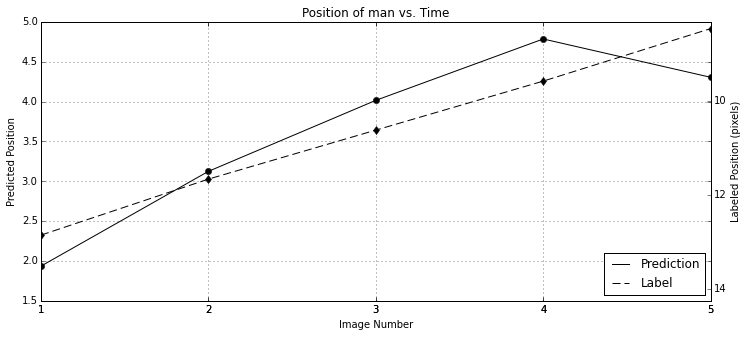

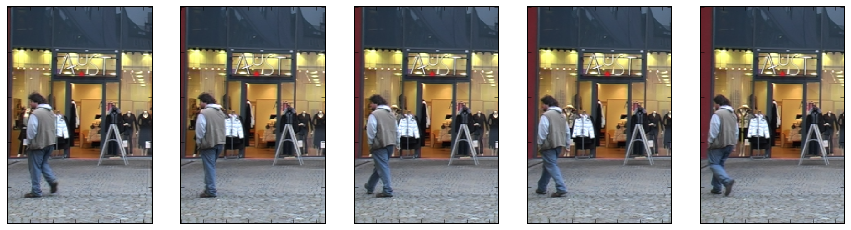

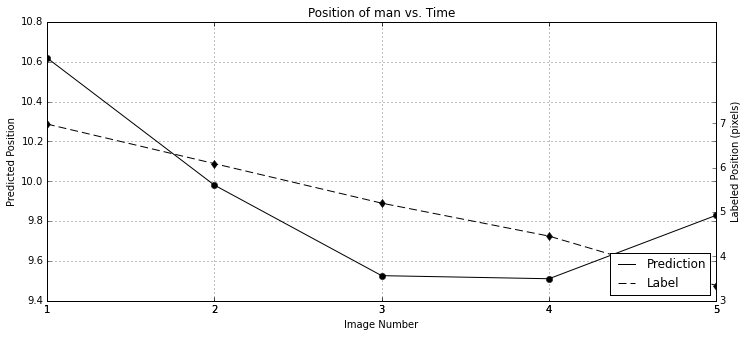

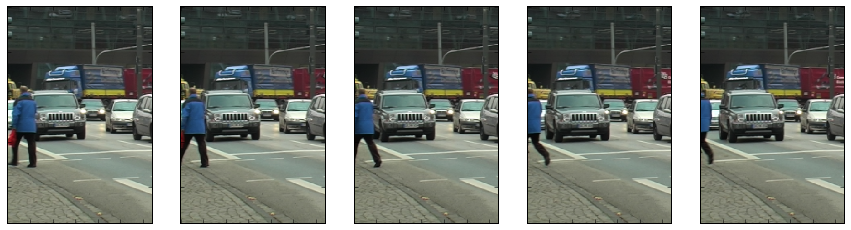

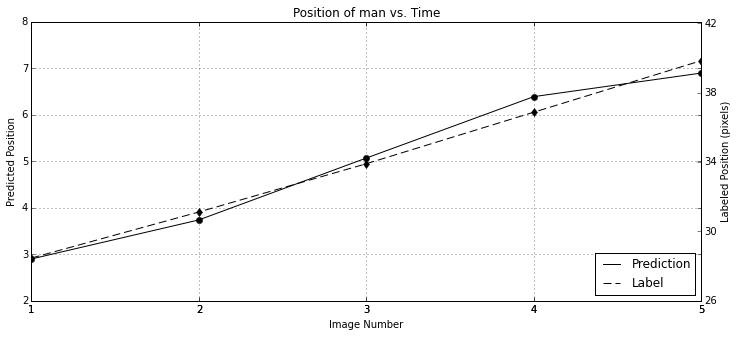

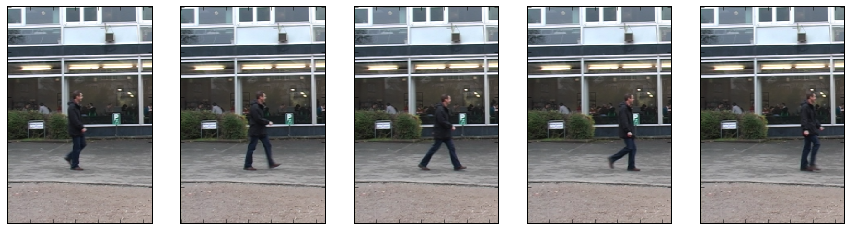

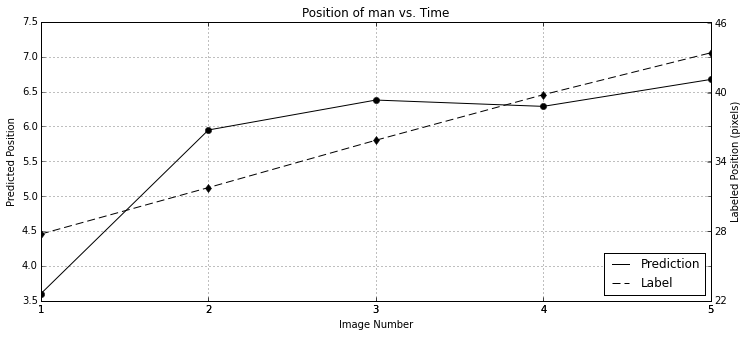

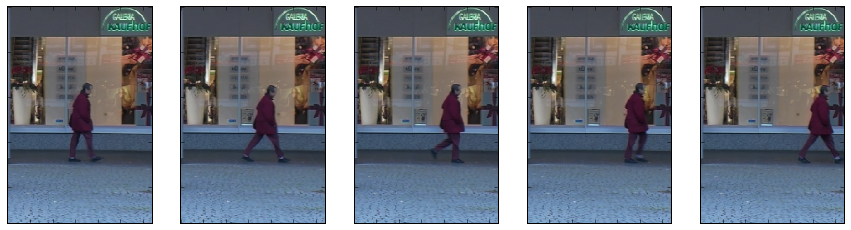

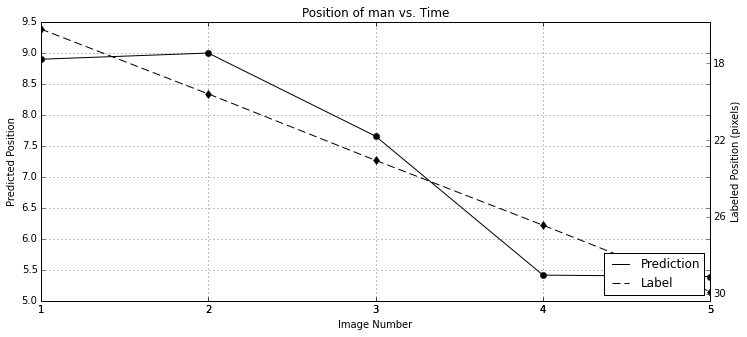

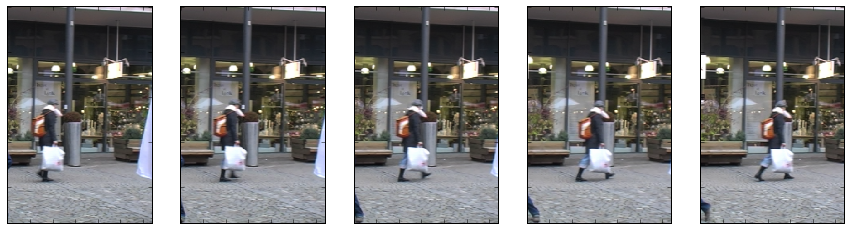

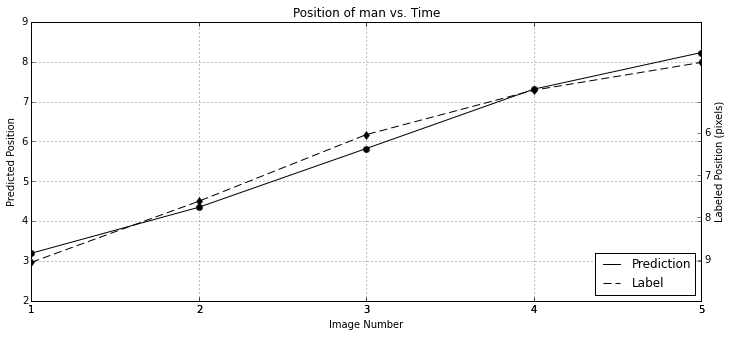

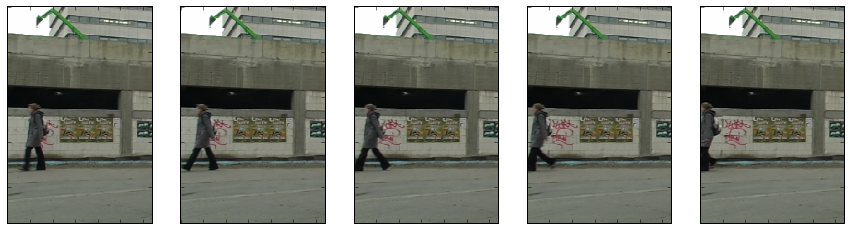

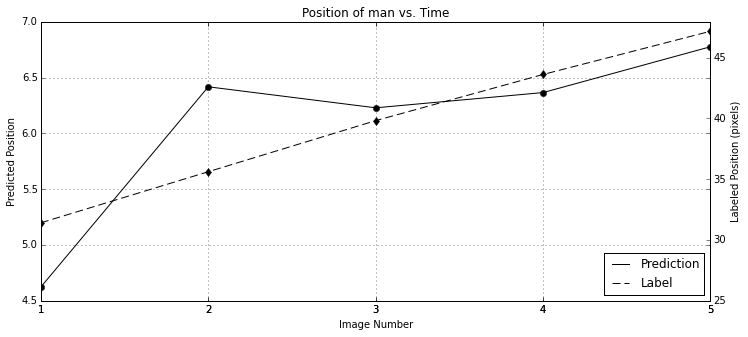

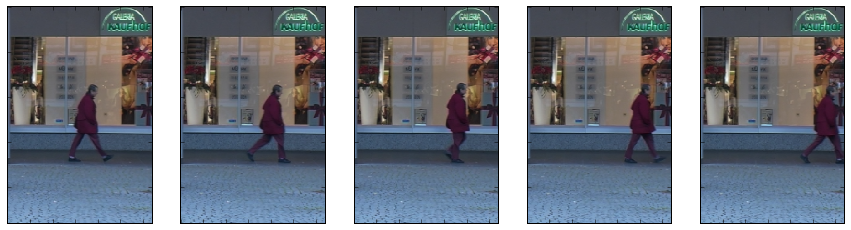

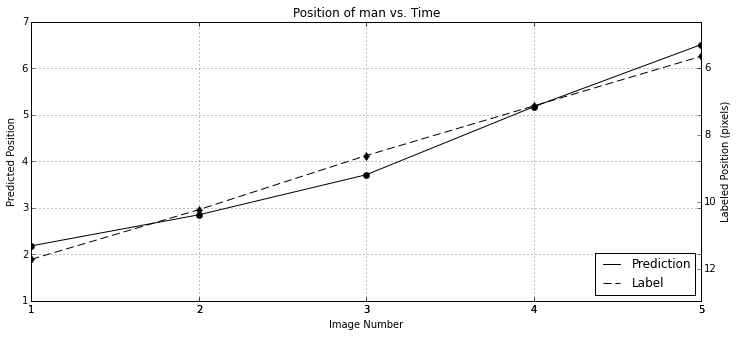

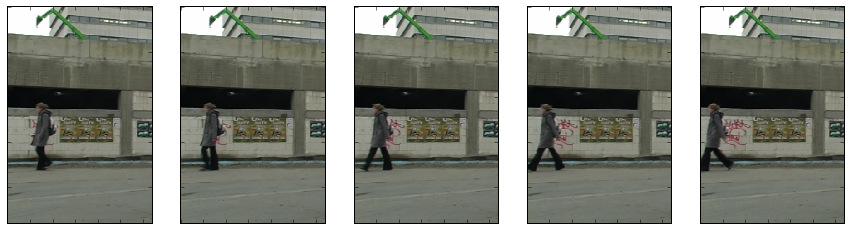

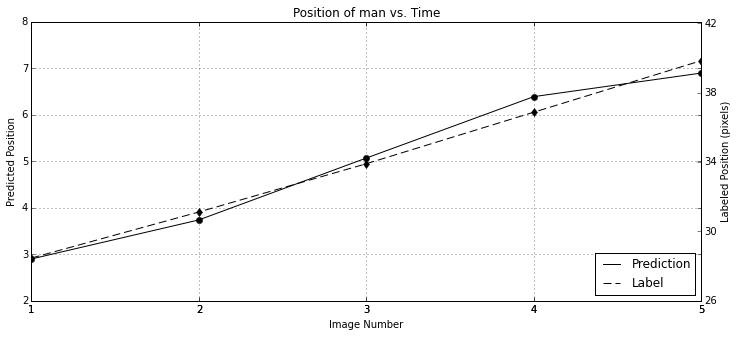

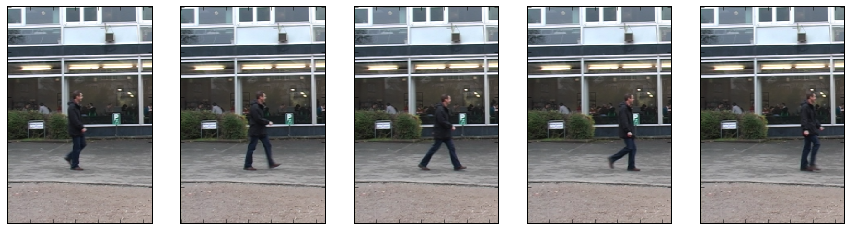

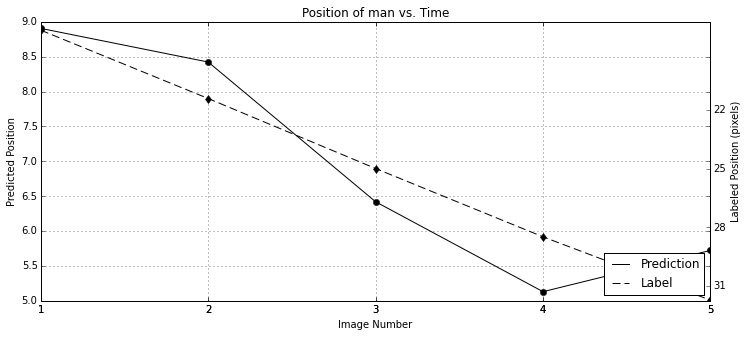

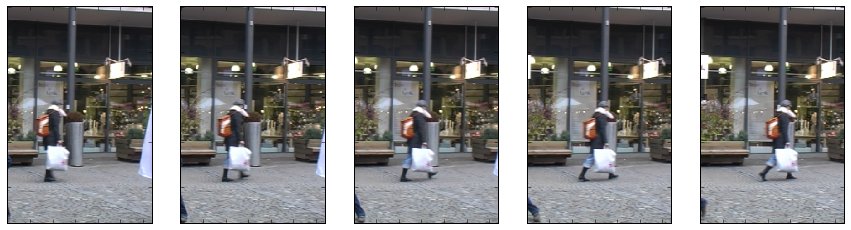

In [12]:
def interp(l):
    x = np.arange(1, 6)
    y = l.T
    return x, y

for n in range(0, 10):
    fig = plt.figure(figsize=(12,5))
    plt_axis = fig.add_subplot(111)
    predictions = np_test_pred_y[n].T
    xnew, ynew = interp(predictions)
    alpha, beta = find_alpha_beta(np_x_label[n, :, 0, 0, 0], predictions)
    print(alpha, beta)
    plt.plot(xnew, ynew, 'k')
    xnew_label, ynew_label = interp(np_x_label[n, :, 0, 0, 0])
    plt.plot(xnew_label, alpha * ynew_label + beta, '-k', dashes=[8, 4])
    plt.plot(range(1, 6), alpha * np_x_label[n, :, 0, 0, 0] + beta, 'kd')
    
    plt.plot(range(1, 6), predictions, 'ko')
    plt.grid()
    plt.title('Position of man vs. Time')
    plt.legend(['Prediction', 'Label'], loc='lower right')
    plt.xlabel('Image Number')
    plt.ylabel('Predicted Position')
    plt.xticks(range(1,6))
    
    ax2 = fig.add_subplot(111, sharex=plt_axis, frameon=False)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    plt.ylabel("Labeled Position (pixels)")
    bot, top = plt_axis.yaxis.get_data_interval()
    def inv(x):
        return 56. / 320. * (scale_down * (x - beta) / alpha)
    new_lims = map(inv, [bot, top])
    pixel_ticks = np.arange(new_lims[0], new_lims[1] + 1.5, (new_lims[1] - new_lims[0]) / 4, dtype=np.int)
    plt.ylim(new_lims)
    plt.yticks(pixel_ticks)
    
    fig = plt.figure(figsize=(15,15))
    for i, im in enumerate(np_x_label[n]):
        im_axis1 = fig.add_subplot('15%d' % (i + 1))
        plt.setp(im_axis1.get_yticklabels(), visible=False)
        plt.setp(im_axis1.get_xticklabels(), visible=False)
        im_axis1.imshow(im * scale_down)

0.934313835268


(array([  2.,   0.,   0.,   7.,  10.,  11.,  11.,  12.,  53.,  54.]),
 array([ 0.69430217,  0.72482375,  0.75534532,  0.7858669 ,  0.81638847,
         0.84691004,  0.87743162,  0.90795319,  0.93847477,  0.96899634,
         0.99951791]),
 <a list of 10 Patch objects>)

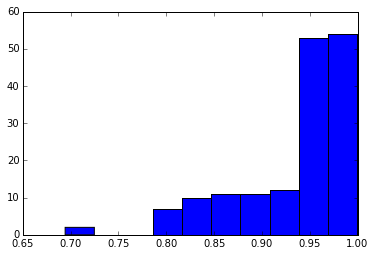

In [14]:
corrs = []
random.seed(1)
for i in range(10):
    eval_data_source = gen_data_batch(batch_size, gen_data_eval)
    np_x_image, np_x_label = eval_data_source.next()
    test_feed = {x_image: np_x_image, keep_prob: 1.0}
    np_test_pred_y = sess.run(pred_y, feed_dict=test_feed)
    for n in range(batch_size):
#         np_test_pred_y = np.array([[random.random() for _ in range(5)] for _ in range(16)])
        label = np_x_label[n][:, 0, 0, 0]
        alpha, beta = find_alpha_beta(label, np_test_pred_y[n].T)
        corrs.append(np.corrcoef(alpha * label + beta,
                                 np_test_pred_y[n].T)[0, 1])
print(np.mean(corrs))
plt.hist(corrs)